In [4]:
# required libraries
import numpy as np
import pandas as pd
from dateutil.parser import ParserError
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt


In [5]:
#chargement du dataset avec pandas
data = pd.read_csv('heart.csv')
data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [6]:
data.shape
#12 attributs 
#918 observations

(918, 12)

In [7]:
#Quels sont les attributs de notre dataset
data.columns

Index(['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS',
       'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope',
       'HeartDisease'],
      dtype='object')

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [9]:
list_features=list(data.columns)
categorical= []
numerical = []

#nombre de valeurs uniques pour chaque colonne s'il y en a beaucoup cela signifie que nous avons une classe numérique

for i in list_features:
    if(len(data[i].unique())>5): 
            numerical.append(i)
    else:
            categorical.append(i)



le=LabelEncoder()

for i in categorical :
    data[i]=le.fit_transform(data[i])

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    int64  
 2   ChestPainType   918 non-null    int64  
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    int64  
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    int64  
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    int64  
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(11)
memory usage: 86.2 KB


In [11]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,918.0,53.510893,9.432617,28.0,47.00,54.0,60.0,77.0
Sex,918.0,0.789760,0.407701,0.0,1.00,1.0,1.0,1.0
ChestPainType,918.0,0.781046,0.956519,0.0,0.00,0.0,2.0,3.0
RestingBP,918.0,132.396514,18.514154,0.0,120.00,130.0,140.0,200.0
Cholesterol,918.0,198.799564,109.384145,0.0,173.25,223.0,267.0,603.0
FastingBS,918.0,0.233115,0.423046,0.0,0.00,0.0,0.0,1.0
RestingECG,918.0,0.989107,0.631671,0.0,1.00,1.0,1.0,2.0
MaxHR,918.0,136.809368,25.460334,60.0,120.00,138.0,156.0,202.0
ExerciseAngina,918.0,0.404139,0.490992,0.0,0.00,0.0,1.0,1.0
Oldpeak,918.0,0.887364,1.066570,-2.6,0.00,0.6,1.5,6.2


In [12]:
# Target
y = np.array(data.HeartDisease)

X = list()
for feat in list(data.columns):
    X.append(list(data[feat]))

# Features
X  = np.array(X[:-1]).T




***On commence par réduire le nombre de dimention de 11 à 2 afin de pouvoir afficher les données***


In [13]:
number_of_features = X.shape[1]

classes = np.unique(y)

number_of_classes = len(classes)

print(f"le nombre de features est : ", number_of_features)
print(f"le nombre de classes est : ", number_of_classes)



le nombre de features est :  11
le nombre de classes est :  2


In [14]:



#Calcul de la moyenne des features
means = np.mean(X, 0)
print(means)

[ 53.51089325   0.78976035   0.78104575 132.39651416 198.79956427
   0.23311547   0.98910675 136.80936819   0.40413943   0.88736383
   1.36165577]


In [15]:
# calcul des scatter matrix


S_w_matrix = np.zeros((number_of_features, number_of_features)) # initialize Within class scatter matrix:

S_b_matrix = np.zeros((number_of_features, number_of_features)) # initialize Between classes scatter matrix:

class_means = []
unique_classes = np.unique(y)
for c in unique_classes:
    class_mean = np.mean(X[y == c], axis=0)
    class_means.append(class_mean)

print(class_means)

[array([5.05512195e+01, 6.51219512e-01, 1.19268293e+00, 1.30180488e+02,
       2.27121951e+02, 1.07317073e-01, 9.48780488e-01, 1.48151220e+02,
       1.34146341e-01, 4.08048780e-01, 1.73902439e+00]), array([ 55.8996063 ,   0.9015748 ,   0.4488189 , 134.18503937,
       175.94094488,   0.33464567,   1.02165354, 127.65551181,
         0.62204724,   1.2742126 ,   1.05708661])]


In [16]:
for c in unique_classes:
    # for each class calculate the 

    X_c = X[y==c]
    mean_c = np.mean(X_c, axis=0)

    S_w_matrix += (X_c - mean_c).T.dot((X_c - mean_c))

    n_c = X_c.shape[0]
    mean_diff = (mean_c - means).reshape(number_of_features, 1)
    S_b_matrix += n_c * (mean_diff).dot(mean_diff.T)

/home/ad/.local/lib/python3.8/site-packages/matplotlib/collections.py:193: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


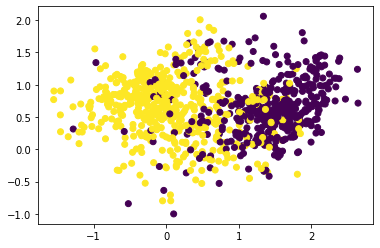

In [17]:



S = np.linalg.inv(S_w_matrix).dot(S_b_matrix)

eigen_values, eigen_vectors = np.linalg.eig(S)

eigenvectors = eigen_vectors.T
idxs = np.argsort(abs(eigen_values))[::-1]
eigenvalues = eigen_values[idxs]
eigenvectors = eigenvectors[idxs]

# store first 2 eigenvectors in case of (we assume that we want to reduce 3D to 2D)
lda = eigenvectors[0:2]



# Project the data
res = np.dot(X, lda.T)


x1 = res[:,0]
x2 = res[:,1]

plt.scatter(x1,x2, c=y)

